# Erzeugung eines Datensatzes für das Training von Text-2-Bild-Modellen

Hugging Face nutzt für den Austausch von Daten das eigene [Datasets-Framework](https://huggingface.co/docs/datasets/index). Im Folgenden soll gezeigt werden, wie sich Bilddaten innerhalb eines Verzeichnisbaum in ein Dataset konvertieren und nach Hugging Face hochladen lässt.

Das Notebook nutzt dabei zusätzlich noch ein freies Modell von Salesforce, welches das Bild beschreiben kann um für ein späteres Modelltraining weitere details in Textform zur Verfügung zu haben.

Gleichzeitig werden die Namen der Ordner im Verzeichnisbaum für die Objektbeschreibung genutzt.

## Installation der nötigen Python Bibliotheken

In [1]:
!pip install -q timm transformers fairscale torch torchvision Pillow datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00


In [39]:
import os
import io
import requests
import pandas as pd
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset, Dataset
from collections import defaultdict
from tqdm import tqdm
from getpass import getpass

In [40]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Modell für die Bildbeschreinung einlesen

In [41]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

## Hilfsfunktionen für die Bildverarbeitung

In [42]:
# Create a image caption with the Blip model
def create_image_caption(path, file):
    img_file = os.path.join(path, file)
    image = Image.open(img_file).convert('RGB')
    text = "a photography of"
    inputs = processor(image, text, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    caption = processor.decode(
        out[0],
        skip_special_tokens=True,
        max_new_tokens=30
    )

    description_path = path.split('/')
    description = description_path[-1]
    if "-" in description:
        description = description.replace("-", " ")

    caption = f"{caption} called {description}"
    return description, caption

In [43]:
def load_image(path):
    with open(path, 'rb') as f:
        im = Image.open(io.BytesIO(f.read()))
        im.thumbnail((512,512))
    return im

In [44]:
def try_load_image(filename):
    try:
        image = load_image(filename)
        if isinstance(image, Image.Image):
            return image
    except Image.UnidentifiedImageError:
        return None

## Verarbeitung des Verzeichnisbaum

Hier werden alle Bilder einbezogen, welche sich im lokalen Verzeichnis ```images/train```befinden.

In [45]:
root_path = 'images/train'
data = defaultdict(list)

In [46]:
for path, dirs, files in os.walk(root_path):
    for file in tqdm(files):
        description, caption = create_image_caption(path, file)
        data['file_name'].append(file)
        data['path'].append(os.path.join(path, file))
        data['caption'].append(caption)
        data['description'].append(description)

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  3.01it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


## Datensatz erzeugen

Aus dem Python Dictonary wird ein Dataset-Objekt erzeugt mit den Attributen
file_name, path, caption, description und image

In [48]:
dataset = Dataset.from_dict(data)

In [49]:
dataset[0]['caption']

'a photography of a toy figure of a man with a sword called heman with axe'

In [50]:
dataset[0]['path']

'images/train/heman-with-axe/he-man-toy007.jpg'

In [51]:
dataset = dataset.map(lambda example: {"image": try_load_image(example['path'])},writer_batch_size=512)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [52]:
dataset

Dataset({
    features: ['file_name', 'path', 'caption', 'description', 'image'],
    num_rows: 9
})

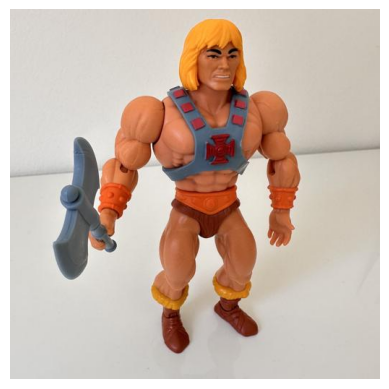

In [53]:
from matplotlib import pyplot as plt
plt.imshow(dataset[0]['image'])
plt.axis("off")
plt.show()

## Dataset Upload

Um das Dataset mit allen Informationen zu Hugging Face zu bekommen, benötigt man nicht nur einen kostenlosen Hugging Face Account sondern auch noch einen API-Token der das schreiben zulässt. Wählen lässt sich noch zwischen einem privaten oder einem public Datensatz. Private sind für die Allgemeinheit nicht lesbar. Das Dataset selber muss man vorher in der Oberfläche angelegt haben um einen direkten Push ausführen zu können

In [24]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [54]:
dataset.push_to_hub('rawar/heman-toy', private=False)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]